In [2]:
import os
# Find the latest version of spark 3.x  from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.4.0'
spark_version = 'spark-3.5.1'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop3.tgz
!tar xf $SPARK_VERSION-bin-hadoop3.tgz
!pip install -q findspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop3"

# Start a SparkSession
import findspark
findspark.init()

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:5 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done


In [6]:
# Import packages
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql.functions import max, min, count, mean
from pyspark.sql.types import StructType,StructField,StringType, DateType,IntegerType


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow import keras
import joblib


In [7]:
!pip install -q -U keras-tuner
from keras_tuner import Hyperband, Objective

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.3 MB/s eta 0:00:00


In [8]:
# Create a SparkSession
spark = SparkSession.builder.appName("SparkSQL").getOrCreate()

# Read CSV File
from google.colab import files
uploaded = files.upload()



/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(


Saving cancer_patient_datasets.csv to cancer_patient_datasets.csv


In [9]:
initial_df = spark.read.csv(("cancer_patient_datasets.csv"), sep=",", header=True)

# Show DataFrame
initial_df.show()


+-----+----------+---+------+-------------+-----------+------------+--------------------+------------+--------------------+-------------+-------+-------+--------------+----------+-----------------+-------+-----------+-------------------+--------+---------------------+------------------------+-------------+---------+-------+------+
|index|Patient Id|Age|Gender|Air Pollution|Alcohol use|Dust Allergy|OccuPational Hazards|Genetic Risk|chronic Lung Disease|Balanced Diet|Obesity|Smoking|Passive Smoker|Chest Pain|Coughing of Blood|Fatigue|Weight Loss|Shortness of Breath|Wheezing|Swallowing Difficulty|Clubbing of Finger Nails|Frequent Cold|Dry Cough|Snoring| Level|
+-----+----------+---+------+-------------+-----------+------------+--------------------+------------+--------------------+-------------+-------+-------+--------------+----------+-----------------+-------+-----------+-------------------+--------+---------------------+------------------------+-------------+---------+-------+------+
|

In [10]:
# 2. Create a temporary view of the DataFrame.
initial_df.createOrReplaceTempView('lung_cancer')

### Initial data exploration

In [11]:
 # What is the youngest and oldest age in our data?
spark.sql("""SELECT min(Age),
max(AGE), mean(AGE)
 FROM lung_cancer""").show()

+--------+--------+---------+
|min(Age)|max(AGE)|mean(AGE)|
+--------+--------+---------+
|      14|      73|   37.174|
+--------+--------+---------+



In [12]:
gender_count_males = spark.sql("""
SELECT
   COUNT(GENDER) Males_with_LC
FROM lung_cancer
WHERE GENDER='1'
""")
gender_count_males.show()


+-------------+
|Males_with_LC|
+-------------+
|          598|
+-------------+



In [13]:
gender_count_females = spark.sql("""
SELECT
   COUNT(GENDER) Females_with_LC
FROM lung_cancer
WHERE GENDER='2'
""")
gender_count_females.show()


+---------------+
|Females_with_LC|
+---------------+
|            402|
+---------------+



In [14]:
smokers_count = spark.sql("""
SELECT
   COUNT(SMOKING) Smokers_with_LC
FROM lung_cancer
WHERE SMOKING > 1
""")

smokers_count.show()

+---------------+
|Smokers_with_LC|
+---------------+
|            819|
+---------------+



In [15]:
df = initial_df.toPandas()
df = pd.DataFrame(df)
df


,index,Patient Id,Age,Gender,Air Pollution,Alcohol use,Dust Allergy,OccuPational Hazards,Genetic Risk,chronic Lung Disease,...,Fatigue,Weight Loss,Shortness of Breath,Wheezing,Swallowing Difficulty,Clubbing of Finger Nails,Frequent Cold,Dry Cough,Snoring,Level
0,0,P1,33,1,2,4,5,4,3,2,...,3,4,2,2,3,1,2,3,4,Low
1,1,P10,17,1,3,1,5,3,4,2,...,1,3,7,8,6,2,1,7,2,Medium
2,2,P100,35,1,4,5,6,5,5,4,...,8,7,9,2,1,4,6,7,2,High
3,3,P1000,37,1,7,7,7,7,6,7,...,4,2,3,1,4,5,6,7,5,High
4,4,P101,46,1,6,8,7,7,7,6,...,3,2,4,1,4,2,4,2,3,High
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,995,P995,44,1,6,7,7,7,7,6,...,5,3,2,7,8,2,4,5,3,High
996,996,P996,37,2,6,8,7,7,7,6,...,9,6,5,7,2,4,3,1,4,High
997,997,P997,25,2,4,5,6,5,5,4,...,8,7,9,2,1,4,6,7,2,High
998,998,P998,18,2,6,8,7,7,7,6,...,3,2,4,1,4,2,4,2,3,High


In [26]:
df = df.drop(columns=['index', 'Patient Id'])
df

,Age,Gender,Air Pollution,Alcohol use,Dust Allergy,OccuPational Hazards,Genetic Risk,chronic Lung Disease,Balanced Diet,Obesity,...,Fatigue,Weight Loss,Shortness of Breath,Wheezing,Swallowing Difficulty,Clubbing of Finger Nails,Frequent Cold,Dry Cough,Snoring,Level
0,33,1,2,4,5,4,3,2,2,4,...,3,4,2,2,3,1,2,3,4,0
1,17,1,3,1,5,3,4,2,2,2,...,1,3,7,8,6,2,1,7,2,1
2,35,1,4,5,6,5,5,4,6,7,...,8,7,9,2,1,4,6,7,2,2
3,37,1,7,7,7,7,6,7,7,7,...,4,2,3,1,4,5,6,7,5,2
4,46,1,6,8,7,7,7,6,7,7,...,3,2,4,1,4,2,4,2,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,44,1,6,7,7,7,7,6,7,7,...,5,3,2,7,8,2,4,5,3,2
996,37,2,6,8,7,7,7,6,7,7,...,9,6,5,7,2,4,3,1,4,2
997,25,2,4,5,6,5,5,4,6,7,...,8,7,9,2,1,4,6,7,2,2
998,18,2,6,8,7,7,7,6,7,7,...,3,2,4,1,4,2,4,2,3,2


In [27]:
df.describe()

,Level
count,1000.000000
mean,1.062000
std,0.815365
min,0.000000
25%,0.000000
50%,1.000000
75%,2.000000
max,2.000000


In [28]:
# check the data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1000 non-null   object
 1   Gender                    1000 non-null   object
 2   Air Pollution             1000 non-null   object
 3   Alcohol use               1000 non-null   object
 4   Dust Allergy              1000 non-null   object
 5   OccuPational Hazards      1000 non-null   object
 6   Genetic Risk              1000 non-null   object
 7   chronic Lung Disease      1000 non-null   object
 8   Balanced Diet             1000 non-null   object
 9   Obesity                   1000 non-null   object
 10  Smoking                   1000 non-null   object
 11  Passive Smoker            1000 non-null   object
 12  Chest Pain                1000 non-null   object
 13  Coughing of Blood         1000 non-null   object
 14  Fatigue                  

In [29]:
# transform levels to int ( fit_transform gives value 1 = low, 2 = medium, 0 = high)

# use rename to reorder
df.Level = df.Level.replace("Low", 0)
df.Level = df.Level.replace("Medium", 1)
df.Level = df.Level.replace("High", 2)

df.Level = df.Level.astype("int64")
df

,Age,Gender,Air Pollution,Alcohol use,Dust Allergy,OccuPational Hazards,Genetic Risk,chronic Lung Disease,Balanced Diet,Obesity,...,Fatigue,Weight Loss,Shortness of Breath,Wheezing,Swallowing Difficulty,Clubbing of Finger Nails,Frequent Cold,Dry Cough,Snoring,Level
0,33,1,2,4,5,4,3,2,2,4,...,3,4,2,2,3,1,2,3,4,0
1,17,1,3,1,5,3,4,2,2,2,...,1,3,7,8,6,2,1,7,2,1
2,35,1,4,5,6,5,5,4,6,7,...,8,7,9,2,1,4,6,7,2,2
3,37,1,7,7,7,7,6,7,7,7,...,4,2,3,1,4,5,6,7,5,2
4,46,1,6,8,7,7,7,6,7,7,...,3,2,4,1,4,2,4,2,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,44,1,6,7,7,7,7,6,7,7,...,5,3,2,7,8,2,4,5,3,2
996,37,2,6,8,7,7,7,6,7,7,...,9,6,5,7,2,4,3,1,4,2
997,25,2,4,5,6,5,5,4,6,7,...,8,7,9,2,1,4,6,7,2,2
998,18,2,6,8,7,7,7,6,7,7,...,3,2,4,1,4,2,4,2,3,2


In [30]:
# convert all columns to integer dtype
for col in df.columns:
    df[col] = df[col].astype(int)

In [31]:
df.dtypes

Age                         int64
Gender                      int64
Air Pollution               int64
Alcohol use                 int64
Dust Allergy                int64
OccuPational Hazards        int64
Genetic Risk                int64
chronic Lung Disease        int64
Balanced Diet               int64
Obesity                     int64
Smoking                     int64
Passive Smoker              int64
Chest Pain                  int64
Coughing of Blood           int64
Fatigue                     int64
Weight Loss                 int64
Shortness of Breath         int64
Wheezing                    int64
Swallowing Difficulty       int64
Clubbing of Finger Nails    int64
Frequent Cold               int64
Dry Cough                   int64
Snoring                     int64
Level                       int64
dtype: object

In [32]:
# Plot using Matplotlib
plt.figure(figsize=(10, 6))
plt.pie(pandas_df['Gender'].value_counts(), labels=["Male", "Female"], autopct='%1.1f%%')
plt.title('Gender Distribution')
plt.savefig('pie.png')
plt.show()


NameError: name 'pandas_df' is not defined

<Figure size 1000x600 with 0 Axes>

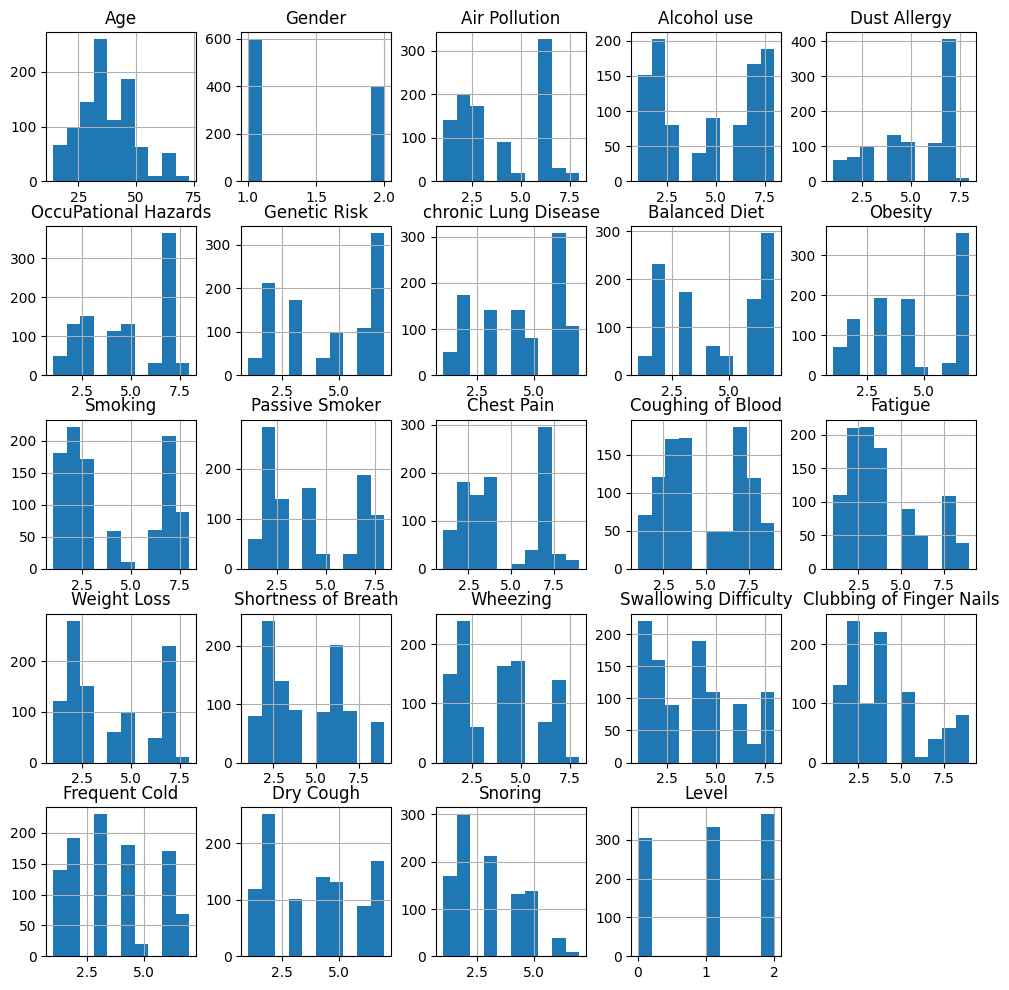

In [33]:
# create a histogram to visualisations
df.hist(figsize=(12,12))
plt.show()

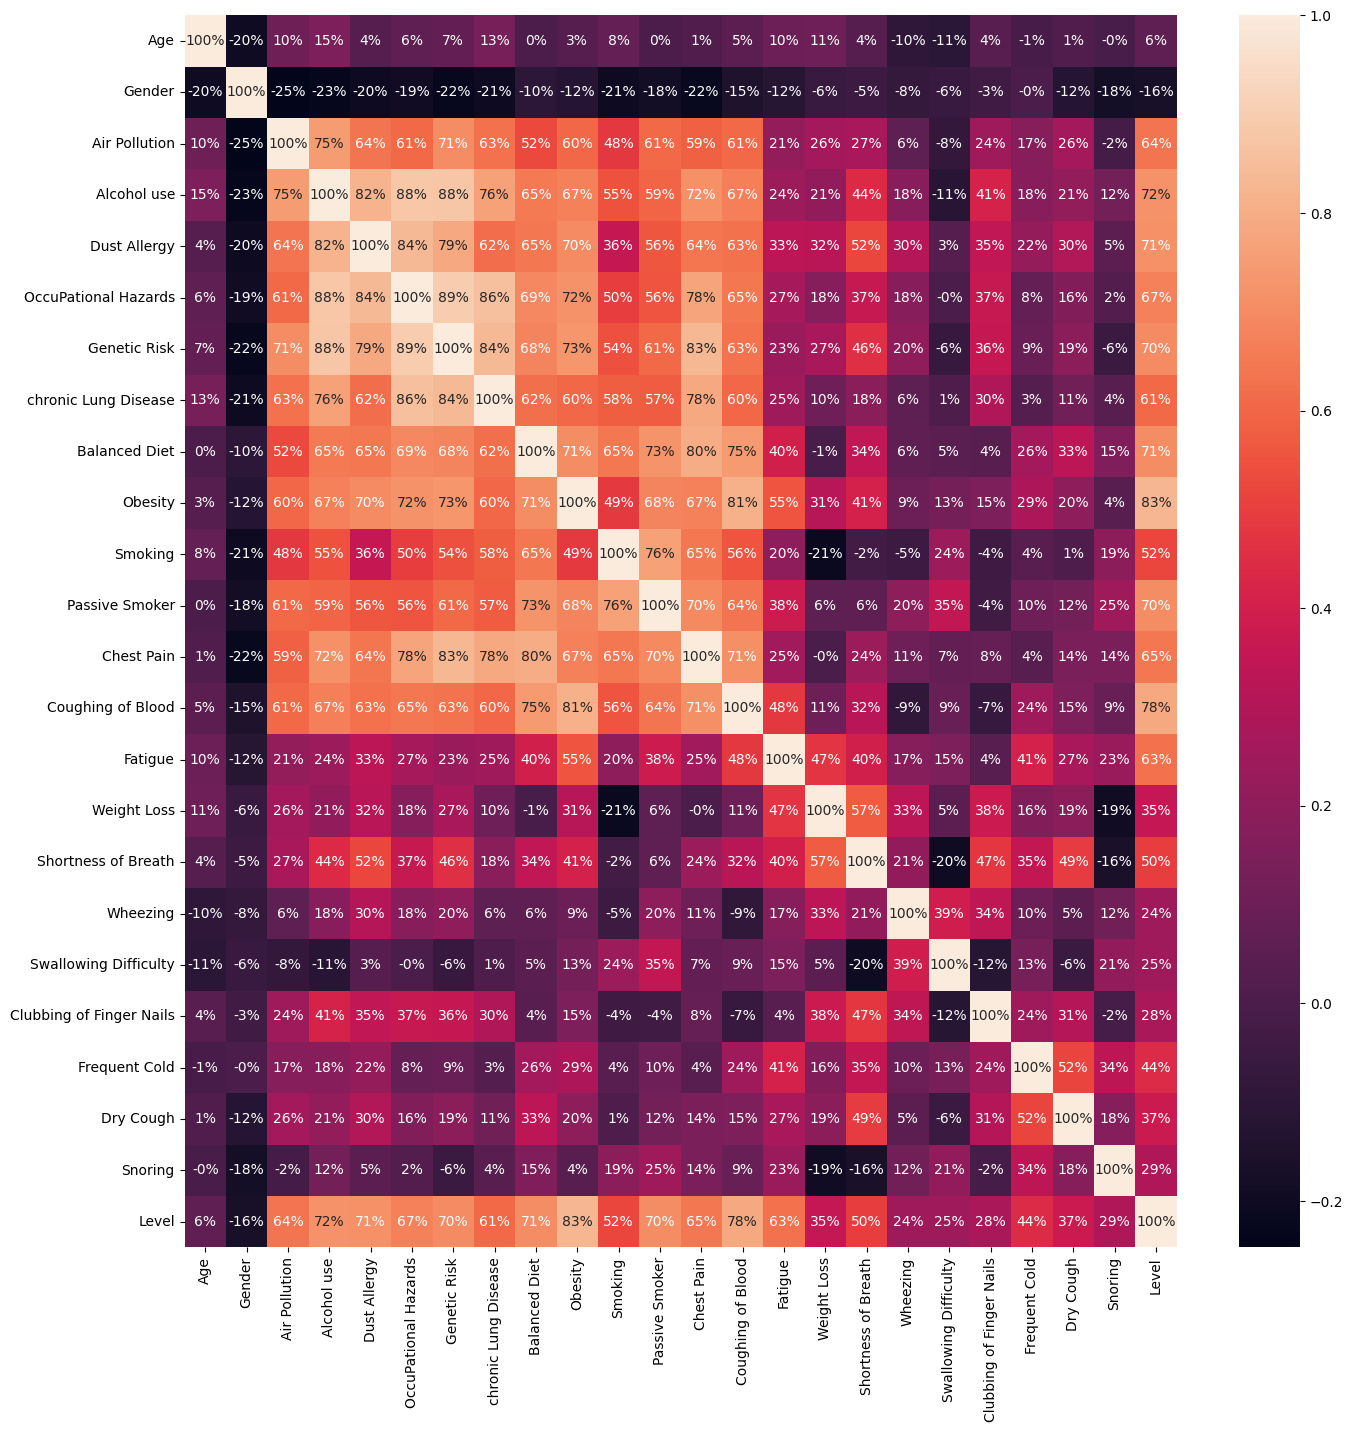

In [34]:
# Plot heatmap using Seaborn
plt.figure(figsize=(16, 16))
sns.heatmap(df.corr(), annot=True, fmt=".0%")
plt.savefig('heatmap.png')
plt.show()


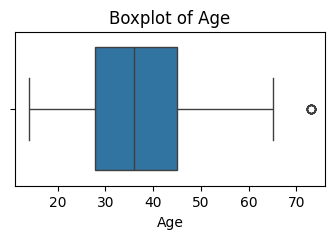

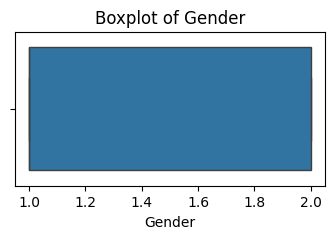

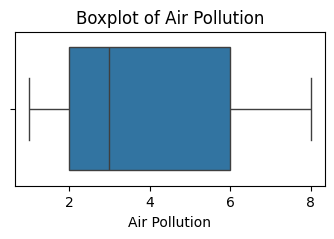

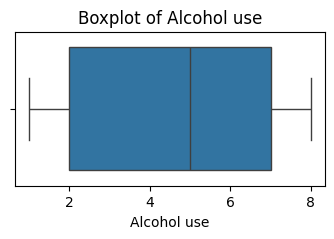

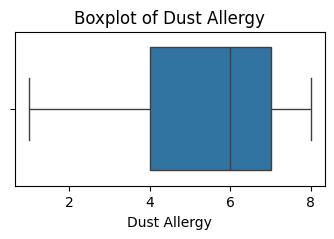

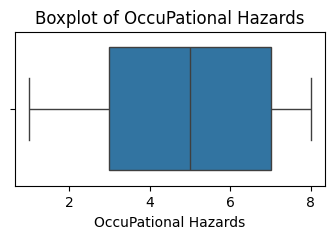

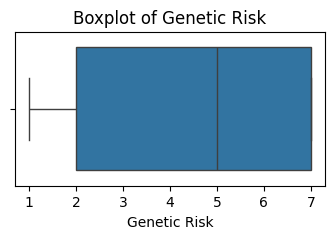

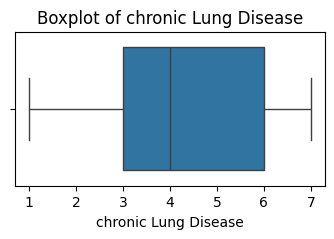

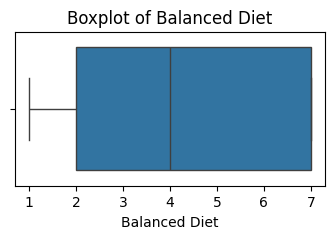

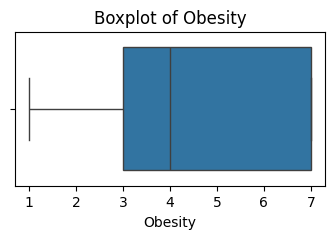

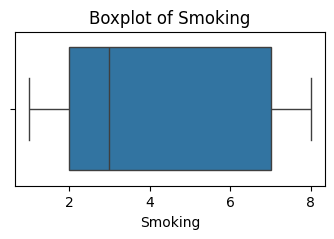

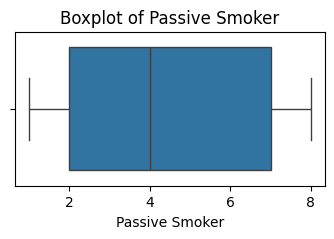

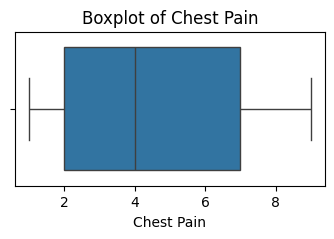

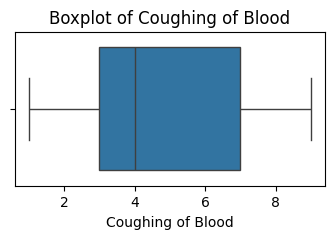

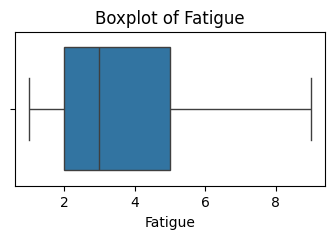

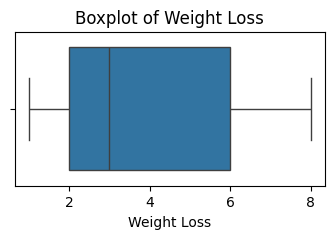

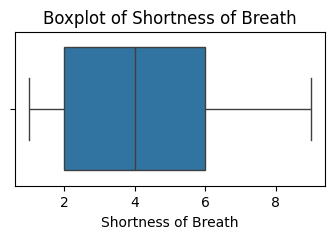

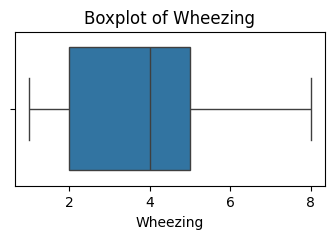

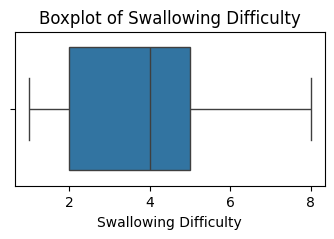

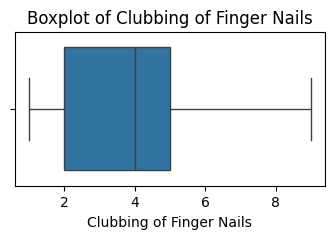

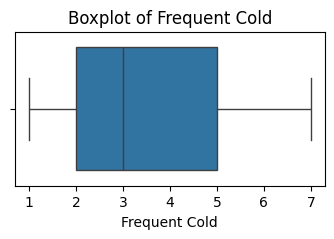

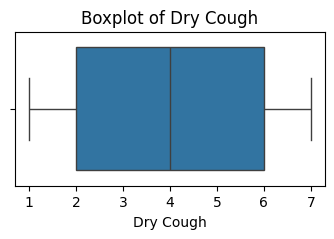

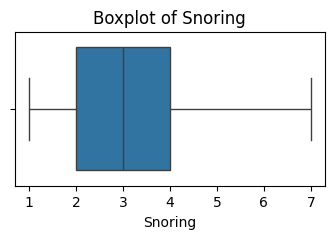

In [35]:
# Create boxplots to show any outliers
boxplot_df = df.drop('Level', axis = 1)
for column in boxplot_df:
  plt.figure(figsize=(4, 2))
  sns.boxplot(x=boxplot_df[column])
  plt.title(f"Boxplot of {column}")
  plt.show()

In [36]:
df['Level'].value_counts()

Level
2    365
1    332
0    303
Name: count, dtype: int64

### Models

In [37]:
# Separate the Features (X) from the Target (y)

X=df.drop('Level',axis=1)

y=df['Level'].values

In [38]:
# split the data into testing and training sets
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=78)

### Logistic regression without scaling

In [39]:
# Instantiate the Logistic Regression model
# Assign a random_state parameter of 1 to the model
logistic_reg = LogisticRegression(solver='liblinear', max_iter=400, random_state=1)

In [40]:
#  Fit (train) or model using the training data
logistic_model = logistic_reg.fit(X_train, y_train)

In [41]:
#Generate testing predictions
testing_prediction = logistic_reg.predict(X_test)
pd.DataFrame({"Prediction": testing_prediction, "Actual": y_test})

#Generate training predictions
training_prediction = logistic_model.predict(X_train)
pd.DataFrame({"Prediction": training_prediction, "Actual": y_train})

,Prediction,Actual
0,0,0
1,0,0
2,2,2
3,0,0
4,0,0
...,...,...
745,2,2
746,0,0
747,2,2
748,1,1


In [42]:
# Generate a confusion matrix for the testing data
testing_matrix = confusion_matrix(y_test, testing_prediction)

print(testing_matrix)

[[72  0  0]
 [ 4 82  0]
 [ 0  0 92]]


In [43]:
# Create a confusion matrix for the training data
training_matrix = confusion_matrix(y_train, training_prediction)

# Print the confusion matrix for the training data
print(training_matrix)

[[231   0   0]
 [ 10 236   0]
 [  0   0 273]]


In [44]:
# Print the classification report for the testing model
testreport = classification_report(y_test, testing_prediction)
accuracy_lr = accuracy_score(y_test, testing_prediction)
print(testreport)
print("Accuracy score is ", accuracy_lr)

              precision    recall  f1-score   support

           0       0.95      1.00      0.97        72
           1       1.00      0.95      0.98        86
           2       1.00      1.00      1.00        92

    accuracy                           0.98       250
   macro avg       0.98      0.98      0.98       250
weighted avg       0.98      0.98      0.98       250

Accuracy score is  0.984


In [45]:
# Print the classification report for the training model
trainreport = classification_report(y_train, training_prediction)
print(trainreport)
accuracy_train = accuracy_score(y_train, training_prediction)
print("Accuracy score is ", accuracy_train)

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       231
           1       1.00      0.96      0.98       246
           2       1.00      1.00      1.00       273

    accuracy                           0.99       750
   macro avg       0.99      0.99      0.99       750
weighted avg       0.99      0.99      0.99       750

Accuracy score is  0.9866666666666667


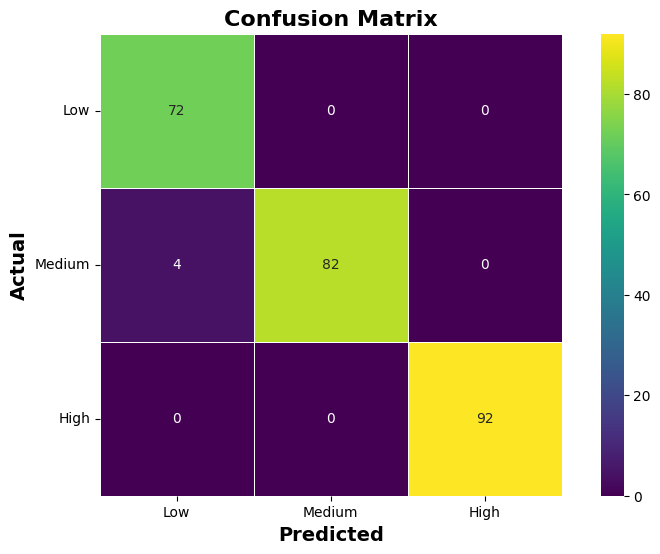

In [46]:
cm = confusion_matrix(y_test, testing_prediction)

plt.figure(figsize=(10, 6))

sns.heatmap(
    cm, annot=True, fmt='d', cmap='viridis', linewidths=0.4, square=True, cbar=True,
    xticklabels=["Low", "Medium", "High"],
    yticklabels=["Low", "Medium", "High"]
)

plt.xlabel('Predicted', fontsize=14, fontweight='bold')
plt.ylabel('Actual', fontsize=14, fontweight='bold')
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.yticks(rotation=360)

plt.show()

### Logistic regression with scaled data

In [47]:
# scale the data
standard_scaler = StandardScaler()
X_train_scaled = standard_scaler.fit_transform(X_train)
X_test_scaled = standard_scaler.transform(X_test)

In [48]:
# apply logistic regression to the scale data
log_reg_scaled = LogisticRegression(solver='liblinear', random_state=42)
log_reg_scaled.fit(X_train_scaled, y_train)
y_pred_standard = log_reg_scaled.predict(X_test_scaled)
accuracy_standard = accuracy_score(y_test, y_pred_standard)
print("Accuracy with Standard scaling:", accuracy_standard)

Accuracy with Standard scaling: 0.976


### Random Forest Classifier

In [49]:
# Create a random forest classifier
rf_model = RandomForestClassifier(n_estimators=500, random_state=78)

In [50]:
# Fitting the model
rf_model = rf_model.fit(X_train_scaled, y_train)

In [51]:
# Making predictions using the testing data
predictions_rf = rf_model.predict(X_test_scaled)

In [52]:
# create a confusion matrix
cm_rf = confusion_matrix(y_test, predictions_rf)
cm_rf

array([[72,  0,  0],
       [ 0, 86,  0],
       [ 0,  0, 92]])

In [53]:
print(classification_report(y_test, predictions_rf))
# Calculating the accuracy score
acc_score_rf = accuracy_score(y_test, predictions_rf)
print("Accuracy with random forest classifier:", acc_score_rf)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        72
           1       1.00      1.00      1.00        86
           2       1.00      1.00      1.00        92

    accuracy                           1.00       250
   macro avg       1.00      1.00      1.00       250
weighted avg       1.00      1.00      1.00       250

Accuracy with random forest classifier: 1.0


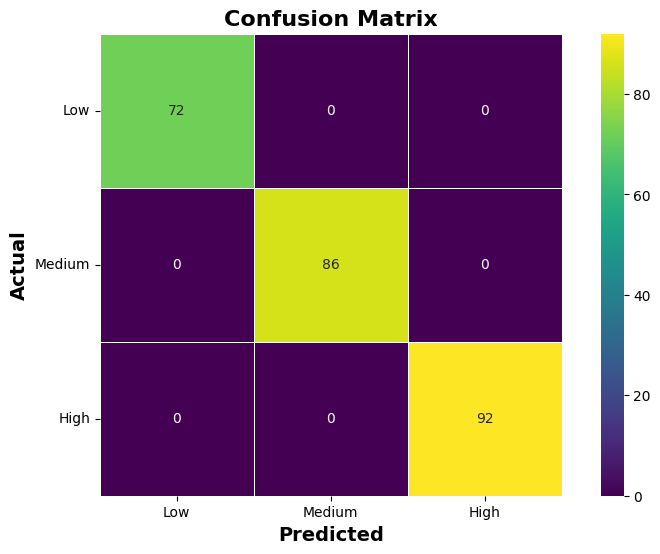

In [54]:
cm = confusion_matrix(y_test, predictions_rf)

plt.figure(figsize=(10, 6))

sns.heatmap(
    cm, annot=True, fmt='d', cmap='viridis', linewidths=0.4, square=True, cbar=True,
    xticklabels=["Low", "Medium", "High"],
    yticklabels=["Low", "Medium", "High"]
)

plt.xlabel('Predicted', fontsize=14, fontweight='bold')
plt.ylabel('Actual', fontsize=14, fontweight='bold')
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.yticks(rotation=360)

plt.show()

In [55]:
# Random Forests in sklearn will automatically calculate feature importance
importances = rf_model.feature_importances_
# We can sort the features by their importance
sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)

[(0.10774866682308047, 'Obesity'),
 (0.1043546159527646, 'Coughing of Blood'),
 (0.09353433850854237, 'Wheezing'),
 (0.09182012719690186, 'Passive Smoker'),
 (0.06200865594225974, 'Fatigue'),
 (0.05341606974589456, 'Balanced Diet'),
 (0.05189954465621297, 'Alcohol use'),
 (0.04151423181992963, 'Shortness of Breath'),
 (0.038696575227073725, 'Smoking'),
 (0.03822757121899644, 'Dust Allergy'),
 (0.03654645581541872, 'Air Pollution'),
 (0.03604383620016289, 'Swallowing Difficulty'),
 (0.034705182752057306, 'Clubbing of Finger Nails'),
 (0.03402383286342143, 'Snoring'),
 (0.02874393164765327, 'OccuPational Hazards'),
 (0.02861631630045619, 'Genetic Risk'),
 (0.02831874858760664, 'Chest Pain'),
 (0.027031442705976006, 'Frequent Cold'),
 (0.022879322668913845, 'Weight Loss'),
 (0.018328375217719885, 'chronic Lung Disease'),
 (0.014640407645264124, 'Dry Cough'),
 (0.006550813891647044, 'Age'),
 (0.0003509366120465224, 'Gender')]

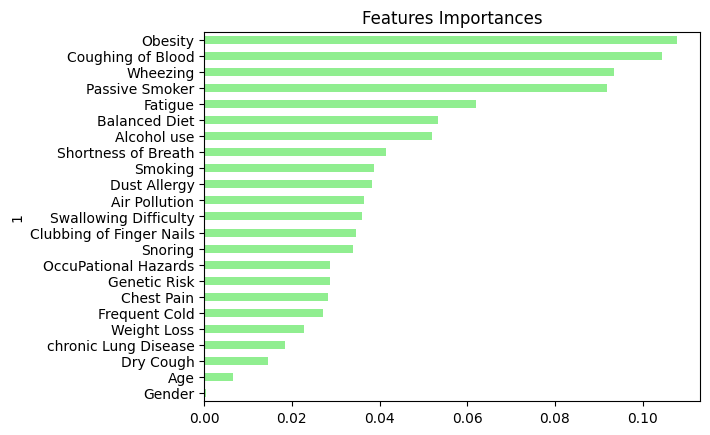

In [56]:
# Visualize the features by importance
importances_df = pd.DataFrame(sorted(zip(rf_model.feature_importances_, X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='lightgreen', title= 'Features Importances', legend=False)
plt.savefig('featuresrandomforest.png')

### Decision Tree model

In [57]:
# Creating the decision tree classifier instance
dtc = DecisionTreeClassifier()

In [58]:
# Fitting the model
dtc_model = dtc.fit(X_train_scaled, y_train)

In [59]:
# Making predictions using the testing data
dtc_predictions = dtc_model.predict(X_test_scaled)

In [60]:
# creating a confusion matrix
cm_dtc = confusion_matrix(y_test, dtc_predictions)
cm_dtc

array([[72,  0,  0],
       [ 0, 86,  0],
       [ 0,  0, 92]])

In [61]:
print(classification_report(y_test, dtc_predictions))
# Calculating the accuracy score
acc_score_dtc = accuracy_score(y_test, dtc_predictions)
print("Accuracy with decision tree classifier:", acc_score_dtc)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        72
           1       1.00      1.00      1.00        86
           2       1.00      1.00      1.00        92

    accuracy                           1.00       250
   macro avg       1.00      1.00      1.00       250
weighted avg       1.00      1.00      1.00       250

Accuracy with decision tree classifier: 1.0


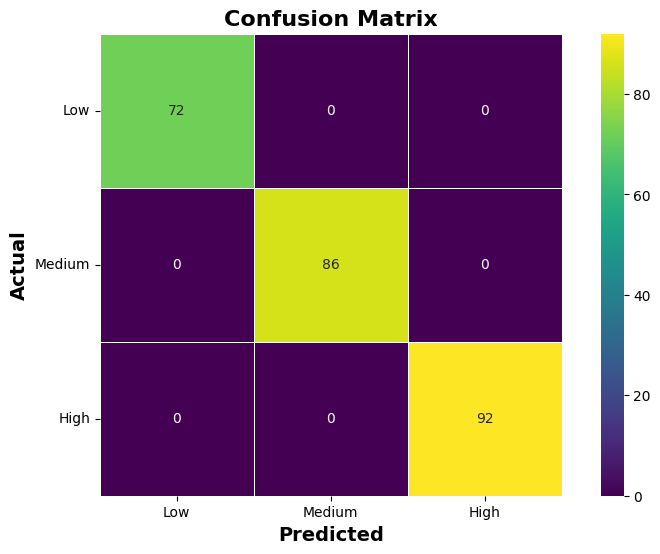

In [62]:
cm = confusion_matrix(y_test, dtc_predictions)

plt.figure(figsize=(10, 6))

sns.heatmap(
    cm, annot=True, fmt='d', cmap='viridis', linewidths=0.4, square=True, cbar=True,
    xticklabels=["Low", "Medium", "High"],
    yticklabels=["Low", "Medium", "High"]
)

plt.xlabel('Predicted', fontsize=14, fontweight='bold')
plt.ylabel('Actual', fontsize=14, fontweight='bold')
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.yticks(rotation=360)

plt.show()

### KNN model

In [63]:
# Instantiate the model with k = 3 neighbours
knn = KNeighborsClassifier(n_neighbors=3)

In [64]:
 # Train the model
knn_model = knn.fit(X_train_scaled, y_train)

In [65]:
# Create predictions
knn_predictions = knn_model.predict(X_test_scaled)
knn_predictions

array([1, 1, 1, 2, 0, 2, 0, 0, 2, 2, 1, 0, 0, 1, 0, 1, 1, 2, 2, 1, 0, 0,
       2, 0, 0, 1, 0, 0, 2, 1, 1, 2, 2, 2, 1, 1, 0, 1, 2, 0, 0, 1, 2, 1,
       2, 2, 2, 0, 1, 1, 2, 1, 0, 1, 1, 1, 2, 2, 0, 2, 2, 0, 1, 0, 2, 2,
       1, 2, 2, 0, 0, 1, 2, 2, 0, 2, 1, 1, 1, 0, 1, 0, 2, 2, 2, 2, 2, 2,
       0, 1, 2, 1, 2, 1, 0, 1, 2, 2, 2, 0, 0, 1, 0, 2, 0, 1, 2, 2, 0, 2,
       2, 2, 0, 2, 1, 1, 1, 1, 2, 0, 0, 2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2,
       1, 0, 1, 2, 1, 1, 2, 1, 1, 0, 1, 0, 2, 0, 2, 0, 0, 1, 2, 0, 0, 1,
       1, 0, 0, 2, 0, 2, 1, 2, 0, 2, 0, 1, 1, 1, 1, 0, 2, 0, 2, 2, 1, 0,
       1, 0, 2, 0, 0, 2, 0, 2, 0, 0, 1, 2, 1, 2, 2, 1, 0, 0, 0, 1, 2, 0,
       2, 2, 1, 1, 2, 2, 2, 1, 0, 1, 2, 1, 2, 1, 1, 2, 2, 1, 1, 1, 2, 2,
       1, 1, 2, 0, 2, 1, 1, 0, 0, 0, 0, 1, 0, 2, 0, 2, 2, 2, 1, 1, 1, 1,
       0, 1, 0, 2, 2, 0, 1, 2])

In [66]:
# creating a confusion matrix
cm_knn = confusion_matrix(y_test, knn_predictions)
cm_knn

array([[72,  0,  0],
       [ 0, 86,  0],
       [ 0,  0, 92]])

In [67]:
print(classification_report(y_test, knn_predictions))
# Calculating the accuracy score
acc_score_knn = accuracy_score(y_test, knn_predictions)
print("Accuracy with decision tree classifier:", acc_score_knn)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        72
           1       1.00      1.00      1.00        86
           2       1.00      1.00      1.00        92

    accuracy                           1.00       250
   macro avg       1.00      1.00      1.00       250
weighted avg       1.00      1.00      1.00       250

Accuracy with decision tree classifier: 1.0


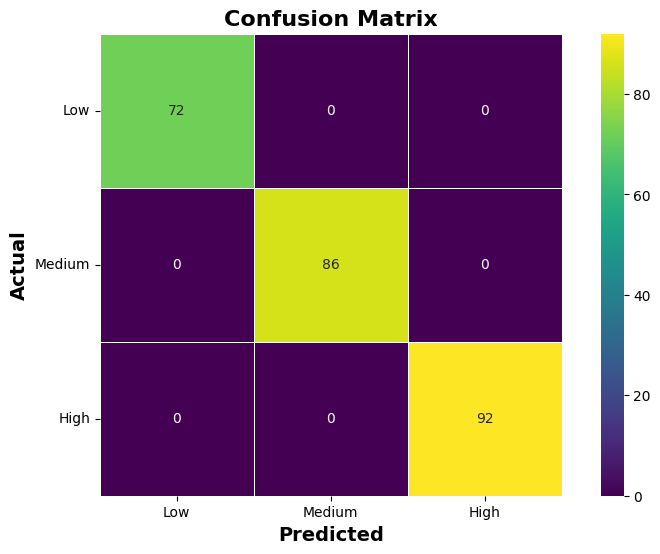

In [68]:
cm = confusion_matrix(y_test, knn_predictions)

plt.figure(figsize=(10, 6))

sns.heatmap(
    cm, annot=True, fmt='d', cmap='viridis', linewidths=0.4, square=True, cbar=True,
    xticklabels=["Low", "Medium", "High"],
    yticklabels=["Low", "Medium", "High"]
)

plt.xlabel('Predicted', fontsize=14, fontweight='bold')
plt.ylabel('Actual', fontsize=14, fontweight='bold')
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.yticks(rotation=360)

plt.show()

### Neural network model

In [69]:
# convert low, medium, high to numeric
df.Level = df.Level.replace("Low", 0)
df.Level = df.Level.replace("Medium", 1)
df.Level = df.Level.replace("High", 2)

df.Level = df.Level.astype("int64")

X = df.drop("Level", axis = 1)
y = pd.get_dummies(df["Level"])

In [70]:
# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

In [71]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# Save the scaler object
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [72]:
def create_model(hp):
    nn_model = tf.keras.models.Sequential()

    # Correctly setting up the choice for activation functions
    activation = hp.Choice('activation', ['relu', 'tanh', 'sigmoid'])

    # Correcting the input shape parameter
    nn_model.add(tf.keras.layers.Dense(
        units=hp.Int('first_units', min_value=1, max_value=128, step=32),
        activation=activation,
        input_shape=(23,)
    ))

    # Adding a range for the number of additional layers
    for i in range(hp.Int('num_layers', 1, 6)):
        nn_model.add(tf.keras.layers.Dense(
            units=hp.Int('units_' + str(i), min_value=1, max_value=128, step=32),
            activation=activation
        ))

    # Assuming 3 classes in the output layer
    nn_model.add(tf.keras.layers.Dense(units=3, activation="softmax"))
    nn_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    return nn_model

### Autotuning for optimisation

In [73]:
tuner = Hyperband(
    create_model,
    objective=Objective("val_accuracy", direction="max"),
    max_epochs=100,
    hyperband_iterations=2,
    directory='hyperband',
    project_name='cancer_classification'
)
tuner.search_space_summary()

Search space summary
Default search space size: 4
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'sigmoid'], 'ordered': False}
first_units (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 6, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 128, 'step': 32, 'sampling': 'linear'}


In [74]:
tuner.search(X_train_scaled, y_train, epochs=10, validation_data=(X_test_scaled, y_test))

Trial 12 Complete [00h 00m 06s]
val_accuracy: 0.6079999804496765

Best val_accuracy So Far: 0.9599999785423279
Total elapsed time: 00h 00m 38s

Search: Running Trial #13

Value             |Best Value So Far |Hyperparameter
sigmoid           |tanh              |activation
1                 |65                |first_units
5                 |1                 |num_layers
65                |65                |units_0
65                |65                |units_1
33                |65                |units_2
33                |33                |units_3
33                |1                 |units_4
65                |97                |units_5
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
4                 |4                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/2


KeyboardInterrupt: 

In [75]:
best_hyper = tuner.get_best_hyperparameters(1)[0]
best_hyper.values

{'activation': 'tanh',
 'first_units': 65,
 'num_layers': 1,
 'units_0': 65,
 'units_1': 65,
 'units_2': 65,
 'units_3': 33,
 'units_4': 1,
 'units_5': 97,
 'tuner/epochs': 2,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 4,
 'tuner/round': 0}

In [76]:
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model
loss, accuracy = best_model.evaluate(X_test_scaled, y_test)
print("Loss:", loss)
print("Accuracy:", accuracy)

8/8 [==============================] - 0s 4ms/step - loss: 0.1757 - accuracy: 0.9600
Loss: 0.17568537592887878
Accuracy: 0.9599999785423279


### Best neural network model and plotting

In [77]:
def calculate_accuracy(y_true, y_pred):
    # find the index with the highest probability
    y_true = tf.argmax(y_true, axis=1)
    y_pred = tf.argmax(y_pred, axis=1)

    # Compare predicted labels to true labels and calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(tf.equal(y_true, y_pred), dtype=tf.float32))

    return accuracy.numpy()

In [78]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_input_features = X_train.shape[1]
hidden_nodes_layer1 =  33


nn1 = tf.keras.models.Sequential()

# First hidden layer
nn1.add(
    tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu")
)


# Output layer
nn1.add(tf.keras.layers.Dense(units=3, activation="softmax"))

# Compile the model
nn1.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Initialize lists to store train and test accuracies
train_accuracies = []
test_accuracies = []

epochs = 12

for e in range(epochs):
    # Fit the model on training data
    nn1.fit(X_train_scaled,y_train,epochs=1)

    # Predict on training data
    y_pred_train = nn1.predict(X_train_scaled)

    # Predict on test data
    y_pred_test = nn1.predict(X_test_scaled)

    # Calculate training accuracy
    train_accuracy = calculate_accuracy(y_train, y_pred_train)

    # Calculate test accuracy
    test_accuracy = calculate_accuracy(y_test, y_pred_test)

    # Append accuracies to lists
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

8/8 [==============================] - 0s 5ms/step


In [79]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn1.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

8/8 - 0s - loss: 0.0801 - accuracy: 1.0000 - 308ms/epoch - 39ms/step
Loss: 0.08011198788881302, Accuracy: 1.0


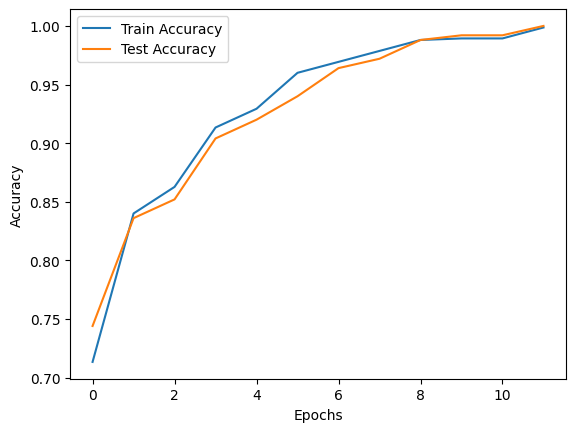

In [80]:
# Plotting
plt.plot(range(epochs), train_accuracies, label='Train Accuracy')
plt.plot(range(epochs), test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('modelaccuracy.png')
plt.show()

In [81]:
# Export our model to HDF5 file
# Define the file path for saving the model
filepath = "Final_model.h5"

# Save the model to HDF5 format
nn1.save(filepath)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
